In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.constants as const
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, ScalarFormatter)
from matplotlib.colors import LogNorm
from scipy import interpolate
from scipy import constants as scp
from scipy.integrate import quad
from scipy.integrate import simps
from scipy.special import kv, airy, gamma
from scipy.optimize import curve_fit
#
from scipy import integrate as int_scp
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import pandas as pd
import os
from glob import glob
import cv2
#
from tqdm import trange, tqdm_notebook
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

In [2]:
import uproot

In [3]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ml = MultipleLocator(2)

In [4]:
def twoD_Gaussian(x_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = x_tuple
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    #h = 0
    return g.ravel()

In [5]:
# Define the Gaussian function
def gaussian(x, A, x0, sigma, c):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2)) + c

## Simulation Parameters

PP with a large hole 50 um diamters, 200 um thickness, 0 deg rotation, 30 x 30 holes.

**Sims parameters**

* PP simulation: 23.25 um and 1.85 mrad
* Laser grating: 2.45 um and 2.65 mrad
* Mean energy: 72 MeV with sigma = 50 meV

In [44]:
# Pepper pot
file = uproot.open("../build-PP-emittance-experiment/Emittance_PP_experiment.root")

# Laser grating
#file = uproot.open("../build-PP-emittance-experiment/Emittance_Laser_Grating_experiment.root")

In [45]:
## Read data from Electrons at lanex
key_id = 'Electrons_Screen;1'
ypos_tuple = file[key_id]['ypos'].array(library="np")
zpos_tuple = file[key_id]['zpos'].array(library="np")
xpos_tuple = file[key_id]['xpos'].array(library="np")

px_tuple = file[key_id]['px'].array(library="np")
py_tuple = file[key_id]['py'].array(library="np")
pz_tuple = file[key_id]['pz'].array(library="np")
#

## Electron hits on the lanex screen

In [46]:
# hits at screen
scale_pos = 10 # mm
binsx = np.linspace(-scale_pos, scale_pos, 400)
binsy = np.linspace(-scale_pos, scale_pos, 400)
#
hist_position, yedges, zedges = np.histogram2d(ypos_tuple, zpos_tuple, bins=(binsx, binsy))
yedges_center = yedges[:-1] + (yedges[1] - yedges[2])/2
zedges_center = zedges[:-1] + (zedges[1] - zedges[2])/2

XX, YY = np.meshgrid(yedges_center, zedges_center)

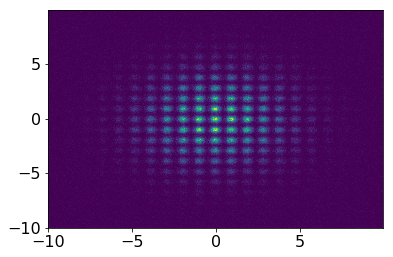

In [47]:
plt.pcolormesh(XX, YY, hist_position)
plt.show()

## Divergence of electrons at screen

In [48]:
# Divergence calculation
z_div_mrad = np.arctan(pz_tuple/px_tuple) * 1e3
y_div_mrad = np.arctan(py_tuple/px_tuple) * 1e3

In [49]:
# divergence at screen
scale_theta = 10 # mm
binsx_theta = np.linspace(-scale_theta, scale_theta, 400)
binsy_theta = np.linspace(-scale_theta, scale_theta, 400)
#
hist_theta, yedges_theta, zedges_theta = np.histogram2d(y_div_mrad, z_div_mrad, bins=(binsx_theta, binsy_theta))
yedges_theta_center = yedges_theta[:-1] + (yedges_theta[1] - yedges_theta[2])/2
zedges_theta_center = zedges_theta[:-1] + (zedges_theta[1] - zedges_theta[2])/2

XX_theta, YY_theta = np.meshgrid(yedges_theta_center, zedges_theta_center)

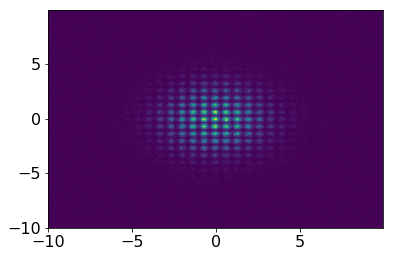

In [50]:
plt.pcolormesh(XX_theta, YY_theta, hist_theta)
plt.show()

## Vertical and Horizontal integrations

In [51]:
## vertical integration
theta_vert_int = np.sum(hist_theta, axis = 0)

In [52]:
## Horizontal integration
theta_horz_int = np.sum(hist_theta, axis = 1)

## Plot the results

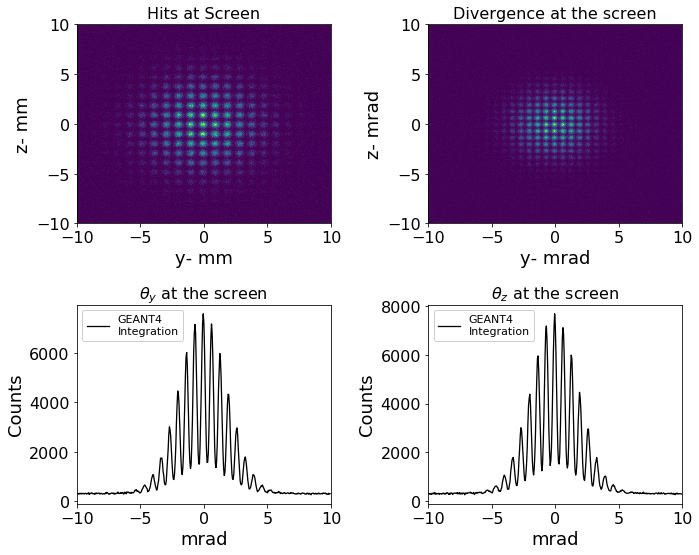

In [53]:
fig, axes1 = plt.subplots(2,2, figsize=(10, 8))
axes = iter(np.ravel(axes1))

###########################################
ax = next(axes)
ax.pcolormesh(XX, YY, hist_position, cmap='viridis')
ax.set_title('Hits at Screen')
ax.set_xlabel('y- mm')
ax.set_ylabel('z- mm')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

###########################################
ax = next(axes)
ax.pcolormesh(XX_theta, YY_theta, hist_theta, cmap='viridis')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_title('Divergence at the screen')
ax.set_xlabel('y- mrad')
ax.set_ylabel('z- mrad')

###########################################
ax = next(axes)
ax.plot(yedges_theta_center, theta_vert_int, label='GEANT4\nIntegration', color='black', lw=1.3)

ax.set_xlim(-10, 10)
#ax.set_ylim(-450, 450)
ax.set_title('$\\theta_y$ at the screen')
ax.set_xlabel('mrad')
ax.set_ylabel('Counts')

ax.legend(loc='upper left', fontsize=11, framealpha=0.95, facecolor='white')


###########################################
ax = next(axes)
ax.plot(zedges_theta_center, theta_horz_int, label='GEANT4\nIntegration', color='black', lw=1.3)

ax.set_xlim(-10, 10)
#ax.set_ylim(-450, 450)
ax.set_title('$\\theta_z$ at the screen')
ax.set_xlabel('mrad')
ax.set_ylabel('Counts')

ax.legend(loc='upper left', fontsize=11, framealpha=0.95, facecolor='white')


plt.tight_layout()

fig.savefig('../build-PP-emittance-experiment/PP_50um_G4_23.25um_1.85mrad.png', dpi=450, facecolor='white', format='png', bbox_inches='tight')
#fig.savefig('../build-PP-emittance-experiment/PP_50um_G4_2.45um_2.65mrad.png', dpi=450, facecolor='white', format='png', bbox_inches='tight')
#2.45 um and 2.65 mrad
plt.show()

## Save the results

In [54]:
x_dir = [zedges_theta_center, theta_horz_int]
#np.savetxt('hits_x_direction_PP_energy_dist.txt', x_dir, fmt='%.9e', delimiter=' ')

In [55]:
y_dir = [yedges_theta_center, theta_vert_int]
#np.savetxt('hits_y_direction_PP_energy_dist.txt', y_dir, fmt='%.9e', delimiter=' ')

## For Alps algorigthm with same magnification

In [56]:
calibration_experiment = 18.5e-3 ## mm/px
scale_pos = 9.99 # mm
nbins = int(scale_pos * 2 / calibration_experiment)
print("Nbins = %.2f"%nbins)


Nbins = 1080.00


In [57]:
# hits at screen
binsx = np.linspace(-scale_pos, scale_pos, nbins)
binsy = np.linspace(-scale_pos, scale_pos, nbins)
#
hist_position, yedges, zedges = np.histogram2d(ypos_tuple, zpos_tuple, bins=(binsx, binsy))
yedges_center = yedges[:-1] + (yedges[1] - yedges[2])/2
zedges_center = zedges[:-1] + (zedges[1] - zedges[2])/2

XX, YY = np.meshgrid(yedges_center, zedges_center)

In [58]:
from PIL import Image
im = Image.fromarray(hist_position)
im.convert("L").save("../build-PP-emittance-experiment/G4sims_PP_calib=18.5um_px.png")
#im.convert("L").save("../build-PP-emittance-experiment/G4sims_Laser_calib=18.5um_px.png")

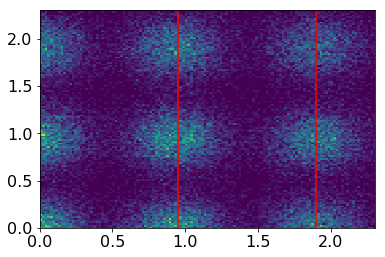

In [59]:
plt.pcolormesh(XX, YY, hist_position.T)
plt.xlim(0, 2.3)
plt.ylim(0, 2.3)
plt.axvline(0.95, c='red')
plt.axvline(1.9, c='red')
plt.show()

# Get  data from all the other screens

## Get Emittance at source

In [28]:
## Read data from Electrons just after source
key_id = 'Electrons_Screen_source;1'
ypos_source_tuple = file[key_id]['ypos'].array(library="np")
zpos_source_tuple = file[key_id]['zpos'].array(library="np")
xpos_source_tuple = file[key_id]['xpos'].array(library="np")

px_source_tuple = file[key_id]['px'].array(library="np")
py_source_tuple = file[key_id]['py'].array(library="np")
pz_source_tuple = file[key_id]['pz'].array(library="np")
#

In [29]:
# hits at screen
scale_pos_source = 0.1 # mm
binsx_source = np.linspace(-scale_pos_source, scale_pos_source, 400)
binsy_source = np.linspace(-scale_pos_source, scale_pos_source, 400)
#
hist_source_position, yedges_source, zedges_source = np.histogram2d(ypos_source_tuple, zpos_source_tuple, 
                                                                    bins=(binsx_source, binsy_source))
yedges_center_source = yedges_source[:-1] + (yedges_source[1] - yedges_source[2])/2
zedges_center_source = zedges_source[:-1] + (zedges_source[1] - zedges_source[2])/2

XX_source, YY_source = np.meshgrid(yedges_center_source, zedges_center_source)

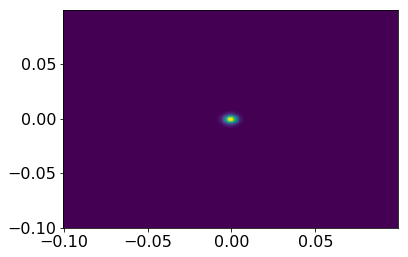

In [30]:
plt.pcolormesh(XX_source, YY_source, hist_source_position)
plt.show()

In [31]:
# Divergence calculation
z_div_mrad_source = np.arctan(pz_source_tuple/px_source_tuple) * 1e3
y_div_mrad_source = np.arctan(py_source_tuple/px_source_tuple) * 1e3

In [32]:
# divergence at screen
scale_theta_source = 10 # mm
binsx_theta_source = np.linspace(-scale_theta_source, scale_theta_source, 400)
binsy_theta_source = np.linspace(-scale_theta_source, scale_theta_source, 400)
#
hist_theta_source, yedges_theta_source, zedges_theta_source = np.histogram2d(y_div_mrad_source,
                                                                             z_div_mrad_source, 
                                                                             bins=(binsx_theta_source, binsy_theta_source))
yedges_theta_center_source = yedges_theta_source[:-1] + (yedges_theta_source[1] - yedges_theta_source[2])/2
zedges_theta_center_source = zedges_theta_source[:-1] + (zedges_theta_source[1] - zedges_theta_source[2])/2

XX_theta_source, YY_theta_source = np.meshgrid(yedges_theta_center_source, zedges_theta_center_source)

In [33]:
# divergence at screen
scale_theta_phase_source = 10 # mm
scale_pos_phase_source = 0.1

binsx_theta_phase_source = np.linspace(-scale_theta_phase_source, scale_theta_phase_source, 400)
binsy_pos_phase_source = np.linspace(-scale_pos_phase_source, scale_pos_phase_source, 401)
#
hist_phase_source, yedges_phase_source, zedges_phase_source = np.histogram2d(zpos_source_tuple, z_div_mrad_source,
                                                        bins=(binsy_pos_phase_source, binsx_theta_phase_source))
yedges_center_source = yedges_phase_source[:-1] + (yedges_phase_source[1] - yedges_phase_source[2])/2
zedges_center_source = zedges_phase_source[:-1] + (zedges_phase_source[1] - zedges_phase_source[2])/2

XX_phase_source, YY_phase_source = np.meshgrid(yedges_center_source, zedges_center_source)

In [34]:
initial_guess = (100,0,0,0.05,5,0,0) # amplitude, xo, yo, sigma_x, sigma_y, theta, offset

#freq_X_crop, freq_Y_crop, far_field_crop

popt, pcov = curve_fit(twoD_Gaussian, (XX_phase_source, YY_phase_source),
                       hist_phase_source.T.ravel(), p0=initial_guess)
print("amplitude, xo, yo, sigma_x, sigma_y, theta, offset")
print(popt)
data_fitted = twoD_Gaussian((XX_phase_source, YY_phase_source), *popt)
#
print("Sigma_x = %.3f mrad"%popt[3])
print("2 x Sigma_x = %.3f mrad"%(2*popt[3]))
print("FWHM_x = %.3f mrad"%(2.35*popt[3]))
print("")
print("Sigma_y = %.3f mm"%popt[4])
print("2 x Sigma_y = %.3f mm"%(2*popt[4]))
print("FWHM_y = %.3f mm"%(2.35*popt[4]))

print("")
emittance_source = popt[3] * popt[4] * 1e3
print("Emittance source = %.5f pi um mrad"%emittance_source)

amplitude, xo, yo, sigma_x, sigma_y, theta, offset
[ 1.70262062e+03 -4.98881275e-04 -5.08436548e-02  2.65434710e-03
  2.44951958e+00  9.01256877e-05  2.86806940e-03]
Sigma_x = 0.003 mrad
2 x Sigma_x = 0.005 mrad
FWHM_x = 0.006 mrad

Sigma_y = 2.450 mm
2 x Sigma_y = 4.899 mm
FWHM_y = 5.756 mm

Emittance source = 6.50188 pi um mrad


FWHM amplitude = 375.0


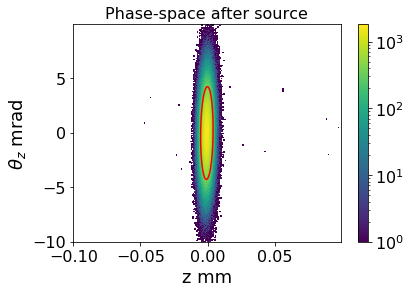

In [35]:
## phase space
plt.pcolormesh(XX_phase_source, YY_phase_source, hist_phase_source.T, norm=LogNorm())
plt.colorbar()
countour_FWHM = twoD_Gaussian((popt[3]*2.35/2, popt[4]*2.35/2), *popt); print("FWHM amplitude = %.1f"%countour_FWHM)
plt.contour(XX_phase_source, YY_phase_source, data_fitted.reshape(hist_phase_source.T.shape[0],
                                                                  hist_phase_source.T.shape[1]), 
           levels=[countour_FWHM], colors=['red'])

#plt.xlim(-scale, scale)
#plt.ylim(-scale/2, scale/2)
plt.xlabel("z mm")
plt.ylabel("$\\theta_z$ mrad")
plt.title('Phase-space after source')
plt.show()

## Get Emittance before PP

In [36]:
## Read data from Electrons just after source
key_id = 'Electrons_Screen_beforePP;1'
ypos_source_tuple = file[key_id]['ypos'].array(library="np")
zpos_source_tuple = file[key_id]['zpos'].array(library="np")
xpos_source_tuple = file[key_id]['xpos'].array(library="np")

px_source_tuple = file[key_id]['px'].array(library="np")
py_source_tuple = file[key_id]['py'].array(library="np")
pz_source_tuple = file[key_id]['pz'].array(library="np")
#

In [37]:
# hits at screen
scale_pos_source = 1 # mm
binsx_source = np.linspace(-scale_pos_source, scale_pos_source, 400)
binsy_source = np.linspace(-scale_pos_source, scale_pos_source, 400)
#
hist_source_position, yedges_source, zedges_source = np.histogram2d(ypos_source_tuple, zpos_source_tuple, 
                                                                    bins=(binsx_source, binsy_source))
yedges_center_source = yedges_source[:-1] + (yedges_source[1] - yedges_source[2])/2
zedges_center_source = zedges_source[:-1] + (zedges_source[1] - zedges_source[2])/2

XX_source, YY_source = np.meshgrid(yedges_center_source, zedges_center_source)

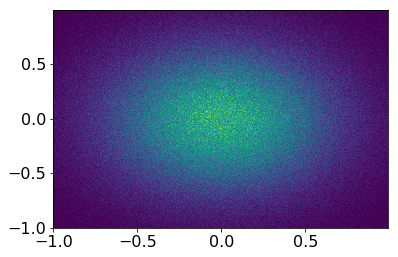

In [38]:
plt.pcolormesh(XX_source, YY_source, hist_source_position)
plt.show()

In [39]:
# Divergence calculation
z_div_mrad_source = np.arctan(pz_source_tuple/px_source_tuple) * 1e3
y_div_mrad_source = np.arctan(py_source_tuple/px_source_tuple) * 1e3

In [40]:
# divergence at screen
scale_theta_source = 10 # mm
binsx_theta_source = np.linspace(-scale_theta_source, scale_theta_source, 400)
binsy_theta_source = np.linspace(-scale_theta_source, scale_theta_source, 400)
#
hist_theta_source, yedges_theta_source, zedges_theta_source = np.histogram2d(y_div_mrad_source,
                                                                             z_div_mrad_source, 
                                                                             bins=(binsx_theta_source, binsy_theta_source))
yedges_theta_center_source = yedges_theta_source[:-1] + (yedges_theta_source[1] - yedges_theta_source[2])/2
zedges_theta_center_source = zedges_theta_source[:-1] + (zedges_theta_source[1] - zedges_theta_source[2])/2

XX_theta_source, YY_theta_source = np.meshgrid(yedges_theta_center_source, zedges_theta_center_source)

In [41]:
# divergence at screen
scale_theta_phase_source = 10 # mm
scale_pos_phase_source = 2

binsx_theta_phase_source = np.linspace(-scale_theta_phase_source, scale_theta_phase_source, 400)
binsy_pos_phase_source = np.linspace(-scale_pos_phase_source, scale_pos_phase_source, 401)
#
hist_phase_source, yedges_phase_source, zedges_phase_source = np.histogram2d(zpos_source_tuple, z_div_mrad_source,
                                                        bins=(binsy_pos_phase_source, binsx_theta_phase_source))
yedges_center_source = yedges_phase_source[:-1] + (yedges_phase_source[1] - yedges_phase_source[2])/2
zedges_center_source = zedges_phase_source[:-1] + (zedges_phase_source[1] - zedges_phase_source[2])/2

XX_phase_source, YY_phase_source = np.meshgrid(yedges_center_source, zedges_center_source)

In [42]:
initial_guess = (100,0,0, 0.1, 2,0,0) # amplitude, xo, yo, sigma_x, sigma_y, theta, offset

#freq_X_crop, freq_Y_crop, far_field_crop

popt, pcov = curve_fit(twoD_Gaussian, (XX_phase_source, YY_phase_source),
                       hist_phase_source.T.ravel(), p0=initial_guess)
print("amplitude, xo, yo, sigma_x, sigma_y, theta, offset")
print(popt)
data_fitted = twoD_Gaussian((XX_phase_source, YY_phase_source), *popt)
#
print("Sigma_x = %.3f mrad"%popt[3])
print("2 x Sigma_x = %.3f mrad"%(2*popt[3]))
print("FWHM_x = %.3f mrad"%(2.35*popt[3]))
print("")
print("Sigma_y = %.3f mm"%popt[4])
print("2 x Sigma_y = %.3f mm"%(2*popt[4]))
print("FWHM_y = %.3f mm"%(2.35*popt[4]))

print("")
emittance_source = popt[3] * popt[4] * 1e3
print("Emittance source = %.5f pi um mrad"%emittance_source)

amplitude, xo, yo, sigma_x, sigma_y, theta, offset
[ 1.86062188e+04 -1.01273343e-02 -5.08188008e-02  4.83131801e-03
  2.48926873e+00  1.78900831e-01 -1.79686244e-01]
Sigma_x = 0.005 mrad
2 x Sigma_x = 0.010 mrad
FWHM_x = 0.011 mrad

Sigma_y = 2.489 mm
2 x Sigma_y = 4.979 mm
FWHM_y = 5.850 mm

Emittance source = 12.02645 pi um mrad


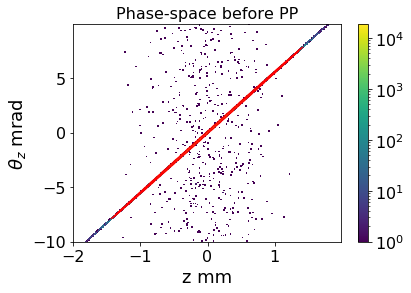

In [43]:
## phase space
plt.pcolormesh(XX_phase_source, YY_phase_source, hist_phase_source.T, norm=LogNorm())
plt.colorbar()
countour_FWHM = twoD_Gaussian((popt[3]*2.35/2, popt[4]*2.35/2), *popt); #print("FWHM amplitude = %.1e"%countour_FWHM)
plt.contour(XX_phase_source, YY_phase_source, data_fitted.reshape(hist_phase_source.T.shape[0],
                                                                  hist_phase_source.T.shape[1]), 
           levels=[90], colors=['red'])

#plt.xlim(-scale, scale)
#plt.ylim(-0.001, 0.001)
plt.xlabel("z mm")
plt.ylabel("$\\theta_z$ mrad")
plt.title('Phase-space before PP')
plt.show()

## Get Emittance after PP

In [456]:
## Read data from Electrons just after source
key_id = 'Electrons_Screen_afterPP;1'
ypos_source_tuple = file[key_id]['ypos'].array(library="np")
zpos_source_tuple = file[key_id]['zpos'].array(library="np")
xpos_source_tuple = file[key_id]['xpos'].array(library="np")

px_source_tuple = file[key_id]['px'].array(library="np")
py_source_tuple = file[key_id]['py'].array(library="np")
pz_source_tuple = file[key_id]['pz'].array(library="np")
#

In [457]:
# hits at screen
scale_pos_source = 1 # mm
binsx_source = np.linspace(-scale_pos_source, scale_pos_source, 400)
binsy_source = np.linspace(-scale_pos_source, scale_pos_source, 400)
#
hist_source_position, yedges_source, zedges_source = np.histogram2d(ypos_source_tuple, zpos_source_tuple, 
                                                                    bins=(binsx_source, binsy_source))
yedges_center_source = yedges_source[:-1] + (yedges_source[1] - yedges_source[2])/2
zedges_center_source = zedges_source[:-1] + (zedges_source[1] - zedges_source[2])/2

XX_source, YY_source = np.meshgrid(yedges_center_source, zedges_center_source)

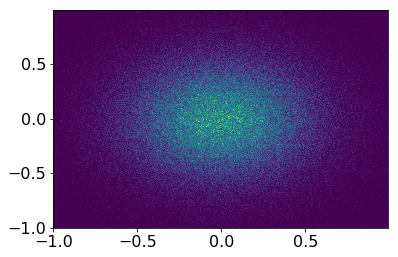

In [458]:
plt.pcolormesh(XX_source, YY_source, hist_source_position)
plt.show()

In [459]:
# Divergence calculation
z_div_mrad_source = np.arctan(pz_source_tuple/px_source_tuple) * 1e3
y_div_mrad_source = np.arctan(py_source_tuple/px_source_tuple) * 1e3

In [460]:
# divergence at screen
scale_theta_source = 10 # mm
binsx_theta_source = np.linspace(-scale_theta_source, scale_theta_source, 400)
binsy_theta_source = np.linspace(-scale_theta_source, scale_theta_source, 400)
#
hist_theta_source, yedges_theta_source, zedges_theta_source = np.histogram2d(y_div_mrad_source,
                                                                             z_div_mrad_source, 
                                                                             bins=(binsx_theta_source, binsy_theta_source))
yedges_theta_center_source = yedges_theta_source[:-1] + (yedges_theta_source[1] - yedges_theta_source[2])/2
zedges_theta_center_source = zedges_theta_source[:-1] + (zedges_theta_source[1] - zedges_theta_source[2])/2

XX_theta_source, YY_theta_source = np.meshgrid(yedges_theta_center_source, zedges_theta_center_source)

In [461]:
# divergence at screen
scale_theta_phase_source = 10 # mm
scale_pos_phase_source = 1.5

binsx_theta_phase_source = np.linspace(-scale_theta_phase_source, scale_theta_phase_source, 400)
binsy_pos_phase_source = np.linspace(-scale_pos_phase_source, scale_pos_phase_source, 401)
#
hist_phase_source, yedges_phase_source, zedges_phase_source = np.histogram2d(zpos_source_tuple, z_div_mrad_source,
                                                        bins=(binsy_pos_phase_source, binsx_theta_phase_source))
yedges_center_source = yedges_phase_source[:-1] + (yedges_phase_source[1] - yedges_phase_source[2])/2
zedges_center_source = zedges_phase_source[:-1] + (zedges_phase_source[1] - zedges_phase_source[2])/2

XX_phase_source, YY_phase_source = np.meshgrid(yedges_center_source, zedges_center_source)

In [463]:
initial_guess = (10,0,0, 2, 0.1,0,0) # amplitude, xo, yo, sigma_x, sigma_y, theta, offset

#freq_X_crop, freq_Y_crop, far_field_crop

popt, pcov = curve_fit(twoD_Gaussian, (XX_phase_source, YY_phase_source),
                       hist_phase_source.T.ravel(), p0=initial_guess)
print("amplitude, xo, yo, sigma_x, sigma_y, theta, offset")
print(popt)
data_fitted = twoD_Gaussian((XX_phase_source, YY_phase_source), *popt)
#
print("Sigma_x = %.3f mrad"%popt[3])
print("2 x Sigma_x = %.3f mrad"%(2*popt[3]))
print("FWHM_x = %.3f mrad"%(2.35*popt[3]))
print("")
print("Sigma_y = %.3f mm"%popt[4])
print("2 x Sigma_y = %.3f mm"%(2*popt[4]))
print("FWHM_y = %.3f mm"%(2.35*popt[4]))

print("")
emittance_source = popt[3] * popt[4] * 1e3
print("Emittance source = %.5f pi um mrad"%emittance_source)

amplitude, xo, yo, sigma_x, sigma_y, theta, offset
[ 9.50060111e+01 -6.29553089e-03 -4.24218269e-02  2.38399123e-02
  1.85684603e+00  1.79022328e-01  7.10335143e-01]
Sigma_x = 0.024 mrad
2 x Sigma_x = 0.048 mrad
FWHM_x = 0.056 mrad

Sigma_y = 1.857 mm
2 x Sigma_y = 3.714 mm
FWHM_y = 4.364 mm

Emittance source = 44.26705 pi um mrad


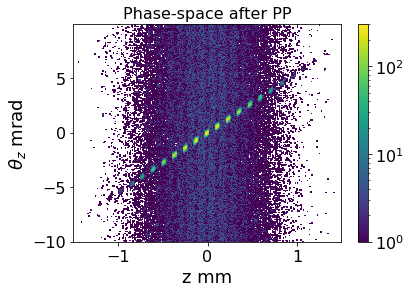

In [462]:
## phase space
plt.pcolormesh(XX_phase_source, YY_phase_source, hist_phase_source.T, norm=LogNorm())
plt.colorbar()

#plt.xlim(-scale, scale)
#plt.ylim(-0.001, 0.001)
plt.xlabel("z mm")
plt.ylabel("$\\theta_z$ mrad")
plt.title('Phase-space after PP')
plt.show()

## Get Emittance at Screen

In [381]:
## Read data from Electrons just after source
key_id = 'Electrons_Screen;1'
ypos_source_tuple = file[key_id]['ypos'].array(library="np")
zpos_source_tuple = file[key_id]['zpos'].array(library="np")
xpos_source_tuple = file[key_id]['xpos'].array(library="np")

px_source_tuple = file[key_id]['px'].array(library="np")
py_source_tuple = file[key_id]['py'].array(library="np")
pz_source_tuple = file[key_id]['pz'].array(library="np")
#

In [382]:
# hits at screen
scale_pos_source = 10 # mm
binsx_source = np.linspace(-scale_pos_source, scale_pos_source, 400)
binsy_source = np.linspace(-scale_pos_source, scale_pos_source, 400)
#
hist_source_position, yedges_source, zedges_source = np.histogram2d(ypos_source_tuple, zpos_source_tuple, 
                                                                    bins=(binsx_source, binsy_source))
yedges_center_source = yedges_source[:-1] + (yedges_source[1] - yedges_source[2])/2
zedges_center_source = zedges_source[:-1] + (zedges_source[1] - zedges_source[2])/2

XX_source, YY_source = np.meshgrid(yedges_center_source, zedges_center_source)

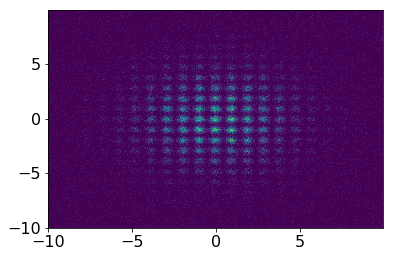

In [383]:
plt.pcolormesh(XX_source, YY_source, hist_source_position)
plt.show()

In [384]:
# Divergence calculation
z_div_mrad_source = np.arctan(pz_source_tuple/px_source_tuple) * 1e3
y_div_mrad_source = np.arctan(py_source_tuple/px_source_tuple) * 1e3

In [385]:
# divergence at screen
scale_theta_source = 10 # mm
binsx_theta_source = np.linspace(-scale_theta_source, scale_theta_source, 400)
binsy_theta_source = np.linspace(-scale_theta_source, scale_theta_source, 400)
#
hist_theta_source, yedges_theta_source, zedges_theta_source = np.histogram2d(y_div_mrad_source,
                                                                             z_div_mrad_source, 
                                                                             bins=(binsx_theta_source, binsy_theta_source))
yedges_theta_center_source = yedges_theta_source[:-1] + (yedges_theta_source[1] - yedges_theta_source[2])/2
zedges_theta_center_source = zedges_theta_source[:-1] + (zedges_theta_source[1] - zedges_theta_source[2])/2

XX_theta_source, YY_theta_source = np.meshgrid(yedges_theta_center_source, zedges_theta_center_source)

In [390]:
# divergence at screen
scale_theta_phase_source = 10 # mm
scale_pos_phase_source = 10

binsx_theta_phase_source = np.linspace(-scale_theta_phase_source, scale_theta_phase_source, 500)
binsy_pos_phase_source = np.linspace(-scale_pos_phase_source, scale_pos_phase_source, 500)
#
hist_phase_source, yedges_phase_source, zedges_phase_source = np.histogram2d(z_div_mrad_source, zpos_source_tuple,
                                                        bins=(binsx_theta_phase_source, binsy_pos_phase_source))

yedges_center_source = yedges_phase_source[:-1] + (yedges_phase_source[1] - yedges_phase_source[2])/2
zedges_center_source = zedges_phase_source[:-1] + (zedges_phase_source[1] - zedges_phase_source[2])/2

XX_phase_source, YY_phase_source = np.meshgrid(yedges_center_source, zedges_center_source)

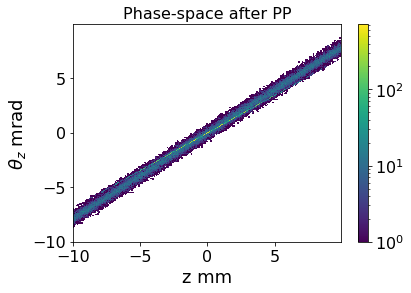

In [391]:
## phase space
plt.pcolormesh(XX_phase_source, YY_phase_source, hist_phase_source, norm=LogNorm())
plt.colorbar()

#plt.xlim(-scale, scale)
#plt.ylim(-0.001, 0.001)
plt.xlabel("z mm")
plt.ylabel("$\\theta_z$ mrad")
plt.title('Phase-space after PP')
plt.show()

In [392]:
initial_guess = (10,0,0, 2, 0.1,0,0) # amplitude, xo, yo, sigma_x, sigma_y, theta, offset

#freq_X_crop, freq_Y_crop, far_field_crop

popt, pcov = curve_fit(twoD_Gaussian, (XX_phase_source, YY_phase_source),
                       hist_phase_source.ravel(), p0=initial_guess)
print("amplitude, xo, yo, sigma_x, sigma_y, theta, offset")
print(popt)
data_fitted = twoD_Gaussian((XX_phase_source, YY_phase_source), *popt)
#
print("Sigma_x = %.3f mrad"%popt[3])
print("2 x Sigma_x = %.3f mrad"%(2*popt[3]))
print("FWHM_x = %.3f mrad"%(2.35*popt[3]))
print("")
print("Sigma_y = %.3f mm"%popt[4])
print("2 x Sigma_y = %.3f mm"%(2*popt[4]))
print("FWHM_y = %.3f mm"%(2.35*popt[4]))

print("")
emittance_source = popt[3] * popt[4] * 1e3
print("Emittance source = %.5f pi um mrad"%emittance_source)

amplitude, xo, yo, sigma_x, sigma_y, theta, offset
[ 3.08418606e+02 -3.55517066e-02 -3.69643986e-02 -3.24816661e+00
  1.87581289e-02 -6.03470605e-01  3.44557777e-01]
Sigma_x = -3.248 mrad
2 x Sigma_x = -6.496 mrad
FWHM_x = -7.633 mrad

Sigma_y = 0.019 mm
2 x Sigma_y = 0.038 mm
FWHM_y = 0.044 mm

Emittance source = -60.92953 pi um mrad
